# F06 G05 2D project 2021

In this project, we are tasked with supporting WHO in developing a model to predict the number of deaths in each country. There are several factors that contribute to the deaths caused by COVID-19, but not all data can be accurately transcribed into values that can be used to predict deaths in a nation or region. However, information such as the number of infected patients, a country's wealth, facilities, the number of vaccinated, the number of completely vaccinated, and the human development index can easily acquire and be incorporated in our model. Considering data from the actual world is not perfectly linear, we will look for data that are strongly correlated. We will be able to predict the number of deaths in a specific nation with assumptions made in any given day using this model.

In this project, we will be using 5 external libraries to aid us in building our model. The libraries are mainly pandas, numpy, seaborn, matplotlib and math. This project is tested and working on python v3.8.3. The cell below will install the requirements for this models.

In [ ]:
pip install -r requirements.txt

In [94]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

This model will make use of modified functions from the homework. Instead of using the mean and standard deviation in normalization, we will use the its maximum and minimum. The data are normalized to avoid variables from overflowing. Normalizing using standard deviation performs for normally distributed data, but because the data in this circumstance is not normally distributed and tends to follow a trend, min-max scaling will be adopted. The feasibility of the model will be determined using functions such as mean squared error, r2 score, adjusted r2 and correlation. While the rest will be employed to predict the model's coefficient.

In [123]:
def normalize_z(df):
    return (df-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))

def normalize_predict(df, dfx):
    return (dfx-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))

def correlation(x, y):
    return x.corr(y)

def prepare_x(df_x):
    xAxis = df_x.to_numpy()
    array1 = np.ones((df_x.shape[0], 1))
    return np.concatenate((array1, xAxis), axis=1)

def prepare_y(df_y):
    return df_y.to_numpy()

def predict(df_x, beta):
    x = prepare_x(df_x)
    return np.matmul(x, beta)

def r2_score(y, ypred):
    ybar = np.mean(y)
    SStot = np.sum((y-ybar)**2)
    SSres = np.sum((y-ypred)**2)
    return 1-SSres/SStot

def mean_squared_error(target, pred):
    n = target.shape[0]
    s = np.sum((target-pred)**2)
    return (1/n)*s

def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    for n in range(num_iters):
        delta = np.matmul(X.T, np.matmul(X, beta) - y)
        beta = beta - (alpha/m)*delta
    return beta

def compute_cost(X, y, beta):
    error = np.matmul(X, beta) - y
    return (1/(2*X.shape[0]))*np.matmul(error.T, error)
    

Since WHO is interested in the prediction of COVID-19 death rate, we will create a statistical representation of the death rate at the global level. Deaths, populations, and policies of individual nations varies by thousands, making it difficult to develop a prediction model. To compensate for the variance, we will normalize all data sets, such as death in thousands, percentage of vaccination in the country, and infected per million. While working on modeling uncertainty in an excel sheet, data is cleaned up. To avoid future indications of unknown null data, we will set the value of all null cells to 0.

In [152]:
# Read csv file
dataFrame = pd.read_csv("2Ddata8.csv")
# Y axis Data
yVal = pd.DataFrame(dataFrame.loc[:, "total_deaths_per_million"].fillna(0))
# X axis Data
xVal = pd.DataFrame(columns=[])
xVal["Days"] = pd.DataFrame(dataFrame["days"].fillna(0))
xVal["Fully_Vaccinated"] = pd.DataFrame(dataFrame["fully_vaccination_percentage"].fillna(0))
xVal["Vaccinated"] = pd.DataFrame(dataFrame["vaccination_percentage"].fillna(0))
xVal["Infected"] = pd.DataFrame(dataFrame["total_cases_per_million"].fillna(0))
xVal["GDP"] = pd.DataFrame(dataFrame["gdp_per_capita"].fillna(0))
xVal["Population"] = pd.DataFrame(dataFrame["population_density"].fillna(0))
xVal["HDI"] = pd.DataFrame(dataFrame["human_development_index"].fillna(0))
xVal["Facilities"] = pd.DataFrame(dataFrame["hospital_beds_per_thousand"].fillna(0))

# Normalise all x-axis columns, convert x-axis and y-axis into arrays
xAxis = prepare_x(normalize_z(xVal))
yAxis = prepare_y(yVal)

iterations, alpha, beta = 10500, 0.05, np.zeros((xAxis.shape[1], 1))
beta = gradient_descent(xAxis, yAxis, beta, alpha, iterations)

However, since the data is skewed, the trained model for a global predict is incompatible for individual countries. The global prediction model will overestimate nations with low death rates and underestimate those with high death rates. As a result, we must train datasets for each countries in order to estimate specific countries' death rates.

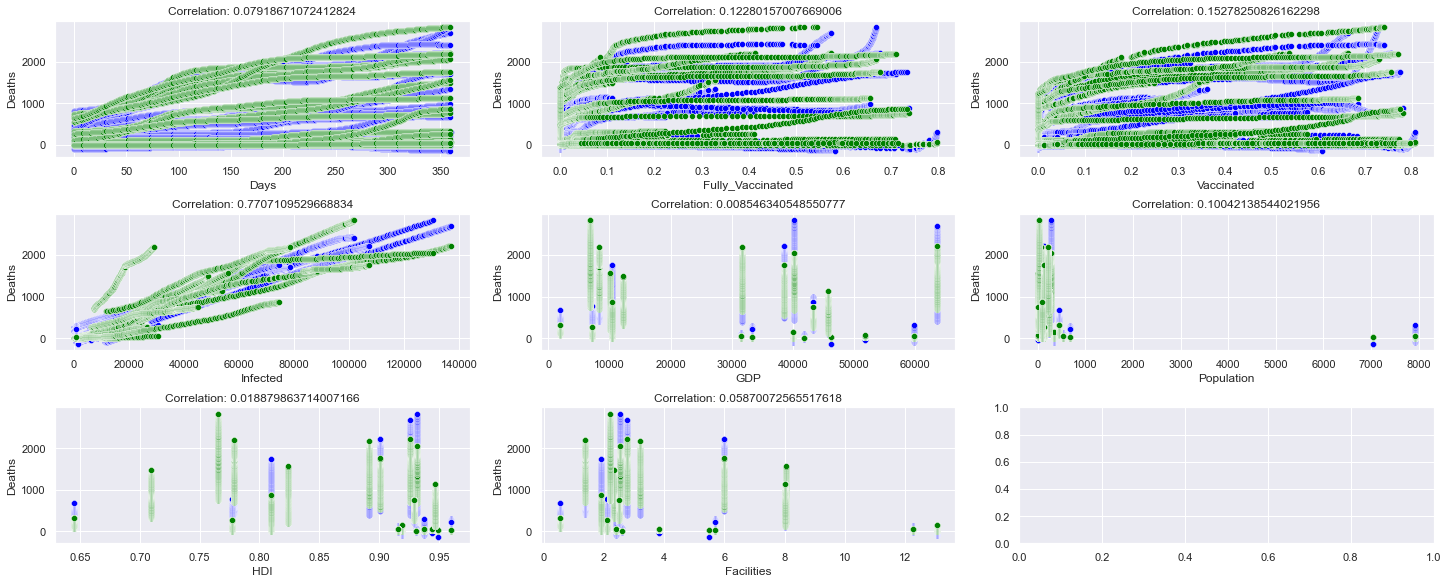

Beta Coefficient:  ['124.7', '-21.82', '-411.53', '228.28', '3029.22', '-796.72', '-28.25', '566.19', '-233.81']
r^2 Value: [0.82] , Adjusted r^2 Value: [0.82]


In [153]:
prediction = pd.DataFrame(predict(normalize_z(xVal), beta))
fig, axs = plt.subplots(math.ceil(len(xVal.columns)/3), 3, figsize=(20, 8), constrained_layout=True)
for index, x in enumerate(xVal.columns):
    sns.set()
    corr = correlation(xVal[x], yVal["total_deaths_per_million"])
    scat0 = sns.scatterplot(x=xVal[x], y=prediction[0], ax=axs[int(index/3), index%3,], color="blue")
    scat1 = sns.scatterplot(x=xVal[x], y=yVal["total_deaths_per_million"], ax=axs[int(index/3), index%3,], color="green")
    scat0.set_title("Correlation: " + str(corr**2))
    scat0.set_ylabel("Deaths")
    scat0.set_xlabel(x)
plt.show()
print("Beta Coefficient: ", [", ".join(x) for x in np.round(beta, 2).astype(str)])
val = r2_score(prepare_y(yVal), prediction).values
print("r^2 Value:", np.round(val, 2), ", Adjusted r^2 Value:", np.round(1-((1-val)*(xVal.shape[0]-1)/(xVal.shape[0]-1-xVal.shape[1])), 2))

The graphs above show a clear relationship between deaths and each individual component. The adjusted r2 score suggests a poor prediction of deaths, which is understandable considering that various countries have differing policies, which may result in skewed statistics. Adjusted r2 score is used to prevent overly optimistic result with the use of unbias data. Countries such as the United States have a high death rate, making it an outlier in this regard. As a result, the actual death rate in the United States significantly differs from the projection. The fully vaccinated and vaccinated chart is as anticipated, as countries with higher vaccination rates should experience lower death rates. In terms of population densities and healthcare facilities, we see that regions with greater population densities have lower death rates, which can be explained by the stringent restrictions that are followed because smaller regions are easier to enforce rules in. Moreover, higher population densities result in a lower health-care facility coefficient. Countries with higher GDP and HDI had higher death rates, which could be explained by the practice of freedom and human rights in those regions where rules are not strictly enforced. In these two graphs, Singapore and Hong Kong are underrepresented due to their low death rates. The model accounts for nations with high and low death rates, which compensate for discrepancies in data. Despite the low adjusted r2 values, the model provides a good average forecast in the global death prediction.

Singapore - Beta Coefficient:  ['4.84', '-1.43', '1.73', '-1.39', '47.93']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


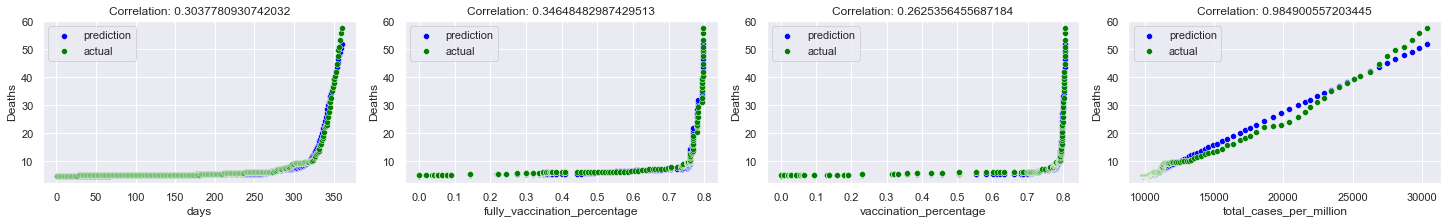

United States - Beta Coefficient:  ['694.5', '-0.58', '-423.34', '659.4', '1294.98']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


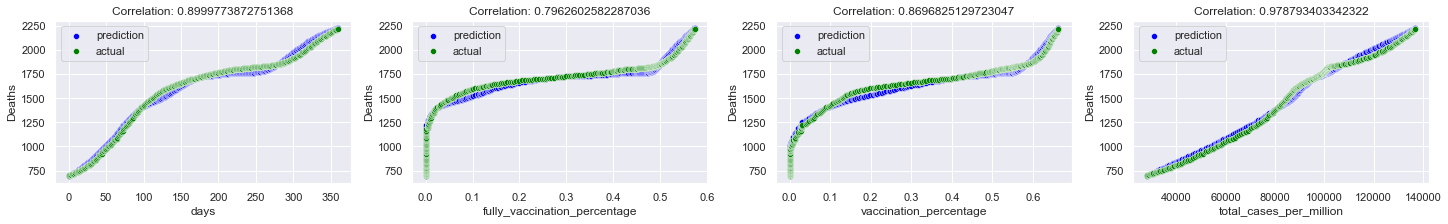

United Kingdom - Beta Coefficient:  ['831.27', '531.73', '-1077.69', '1228.1', '667.31']
r^2 Value: [0.97] , Adjusted r^2 Value: [0.97]


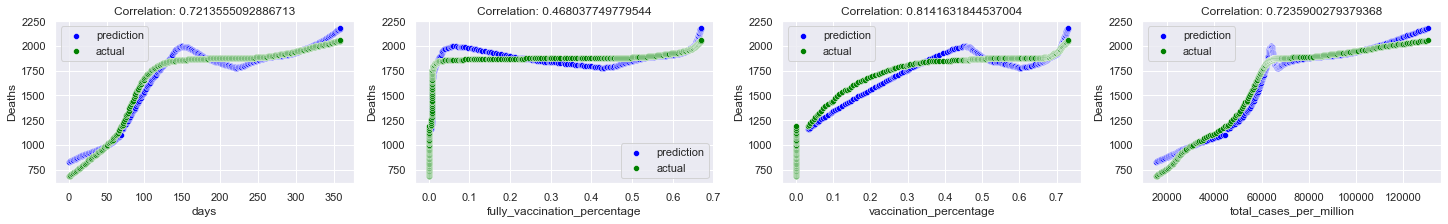

Japan - Beta Coefficient:  ['4.7', '152.71', '-50.25', '20.22', '17.42']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


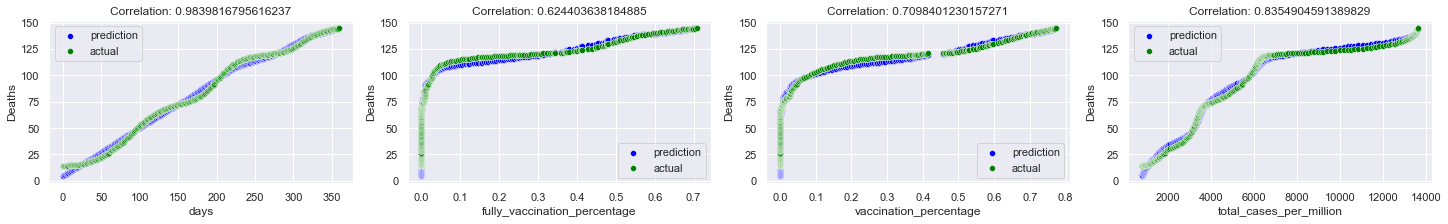

Hong Kong - Beta Coefficient:  ['12.49', '6.88', '-3.21', '-0.86', '13.35']
r^2 Value: [0.98] , Adjusted r^2 Value: [0.98]


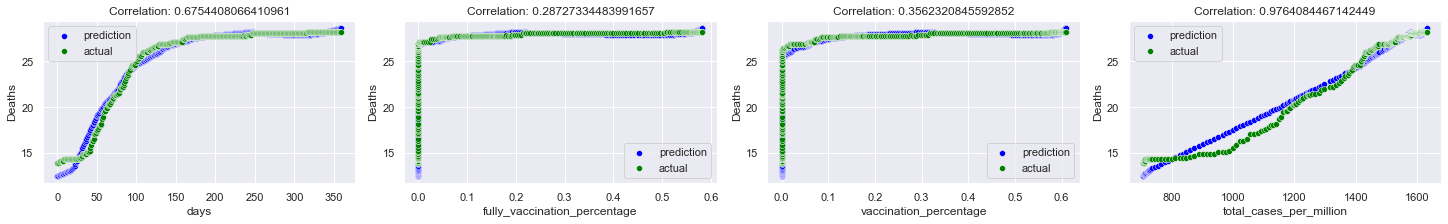

New Zealand - Beta Coefficient:  ['5.11', '0.22', '0.02', '-0.21', '0.73']
r^2 Value: [0.89] , Adjusted r^2 Value: [0.89]


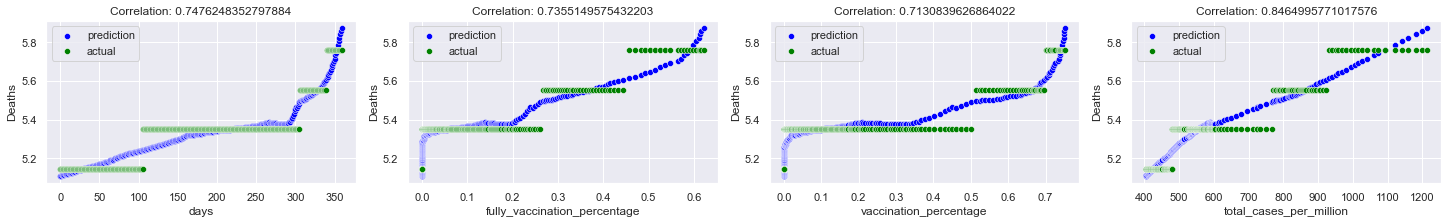

Australia - Beta Coefficient:  ['35.09', '0.3', '5.15', '-4.87', '27.54']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


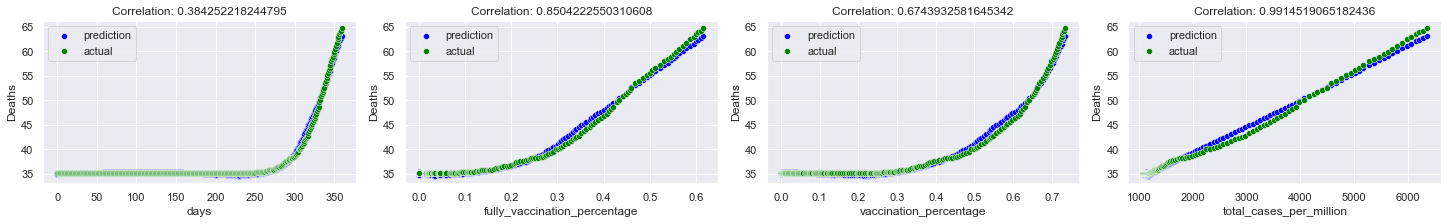

India - Beta Coefficient:  ['90.6', '-26.59', '-23.03', '80.95', '208.51']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


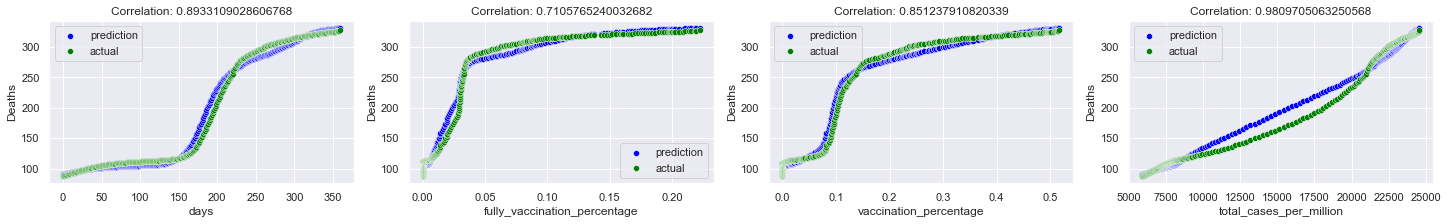

South Africa - Beta Coefficient:  ['316.59', '546.79', '207.2', '-364.98', '775.14']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


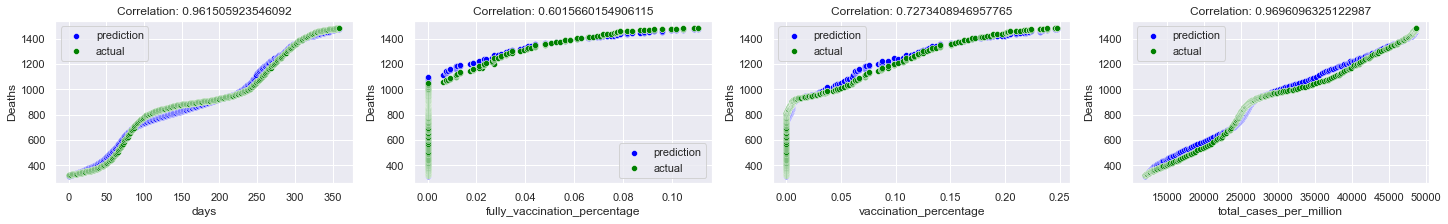

Mexico - Beta Coefficient:  ['639.31', '1315.37', '-362.68', '-293.21', '886.41']
r^2 Value: [1.] , Adjusted r^2 Value: [1.]


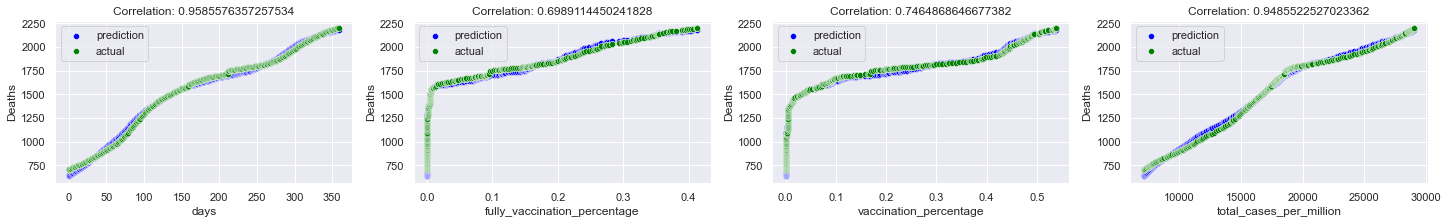

Russia - Beta Coefficient:  ['178.4', '420.14', '248.52', '43.07', '622.91']
r^2 Value: [1.] , Adjusted r^2 Value: [1.]


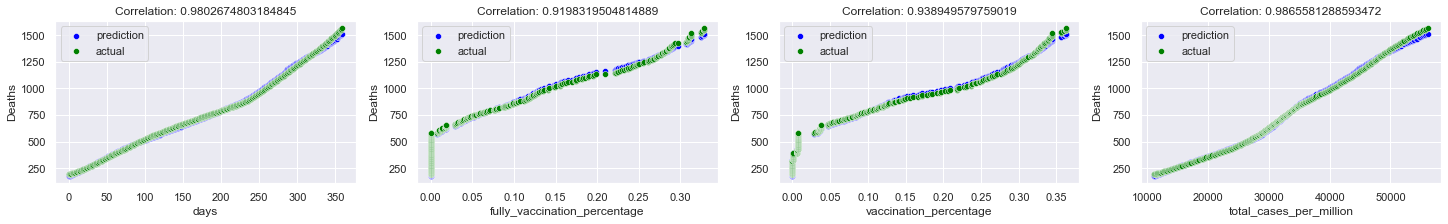

Brazil - Beta Coefficient:  ['628.43', '495.72', '-372.32', '461.24', '1603.6']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


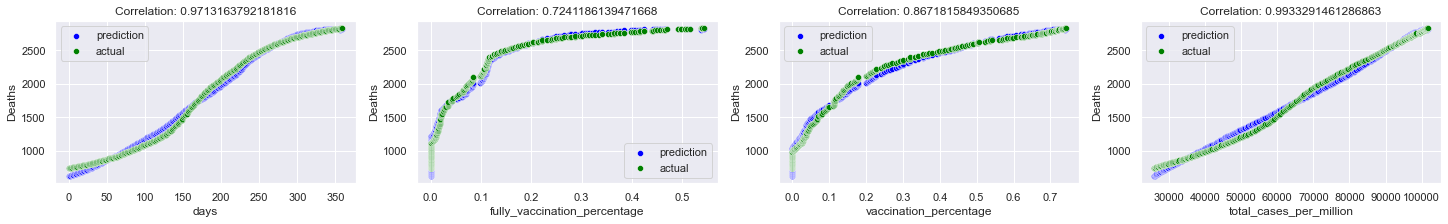

South Korea - Beta Coefficient:  ['9.09', '42.0', '1.52', '-27.68', '28.66']
r^2 Value: [0.97] , Adjusted r^2 Value: [0.97]


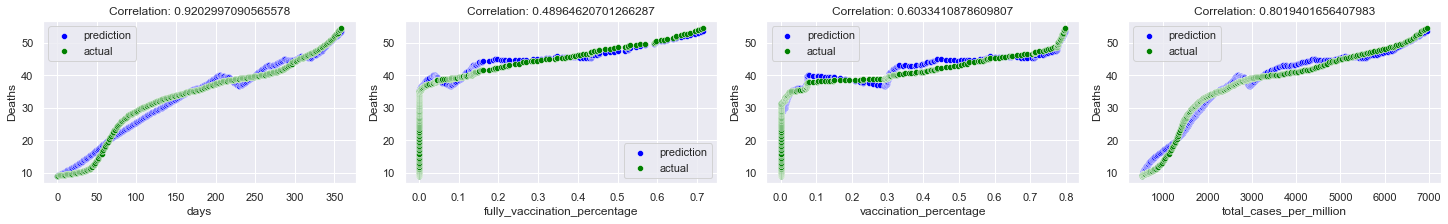

Germany - Beta Coefficient:  ['57.2', '583.16', '-337.43', '-102.91', '1077.99']
r^2 Value: [0.97] , Adjusted r^2 Value: [0.97]


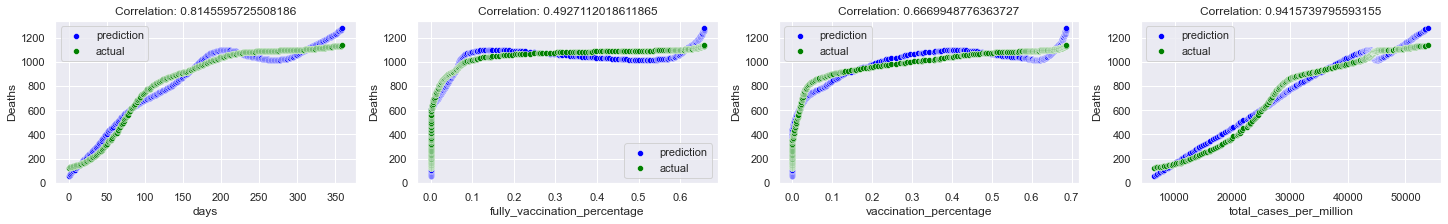

Thailand - Beta Coefficient:  ['4.64', '-23.68', '40.77', '85.74', '180.28']
r^2 Value: [1.] , Adjusted r^2 Value: [1.]


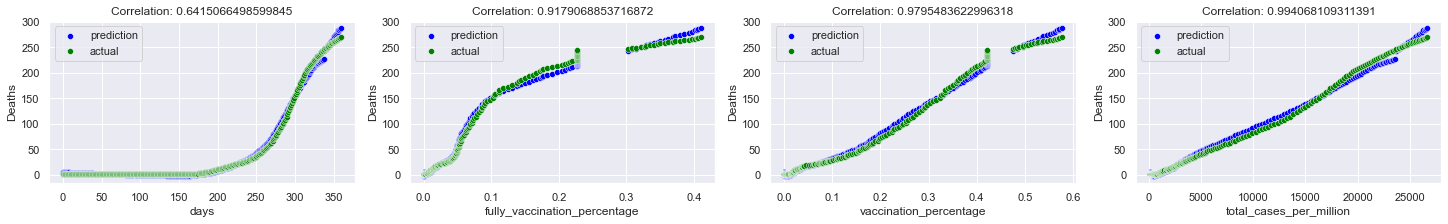

France - Beta Coefficient:  ['614.53', '862.92', '-521.02', '11.17', '857.88']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


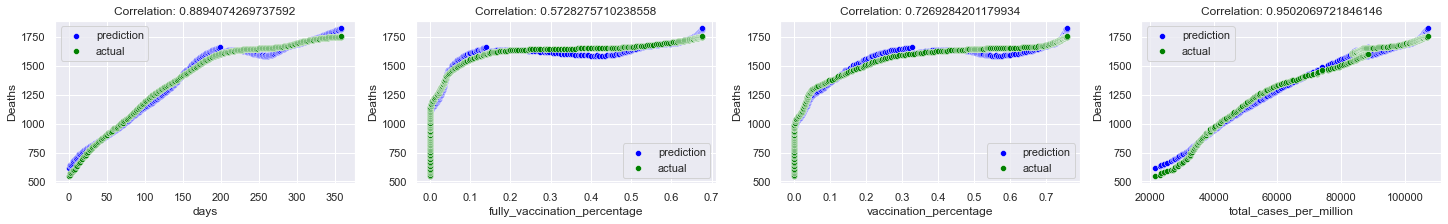

Canada - Beta Coefficient:  ['270.65', '287.64', '-68.17', '-151.9', '457.3']
r^2 Value: [0.98] , Adjusted r^2 Value: [0.98]


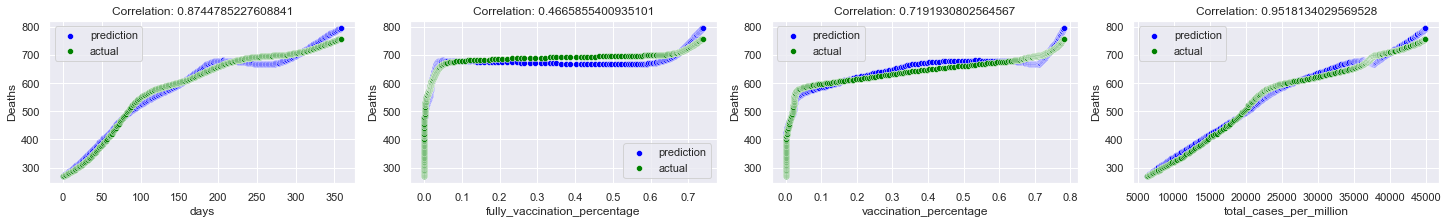

Italy - Beta Coefficient:  ['617.5', '618.8', '-437.13', '41.14', '1404.48']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


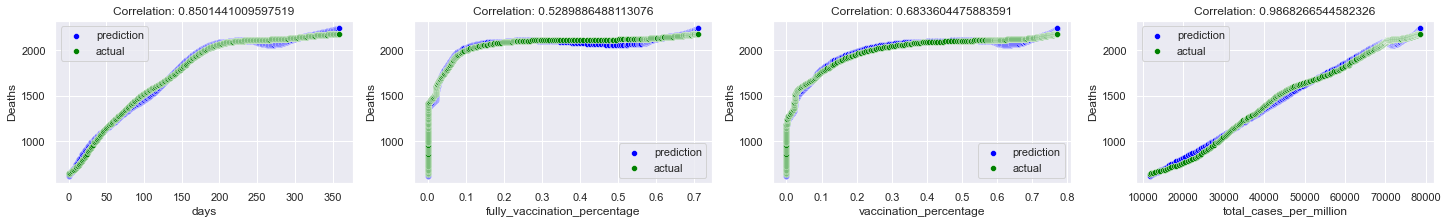

Malaysia - Beta Coefficient:  ['10.26', '-65.31', '517.26', '1.33', '396.41']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


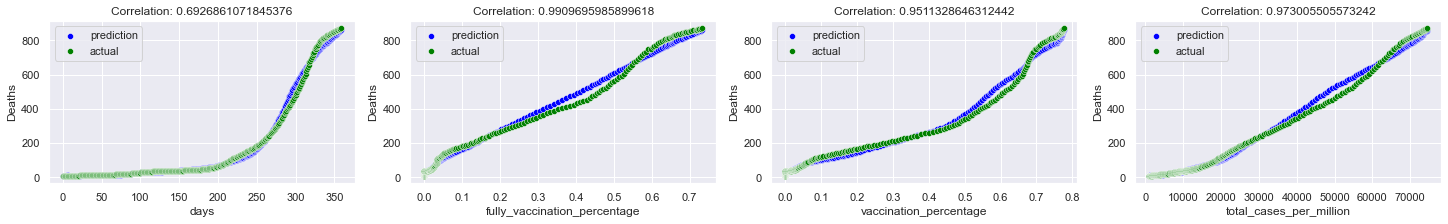

Taiwan - Beta Coefficient:  ['0.79', '-4.89', '-9.62', '21.2', '27.3']
r^2 Value: [0.99] , Adjusted r^2 Value: [0.99]


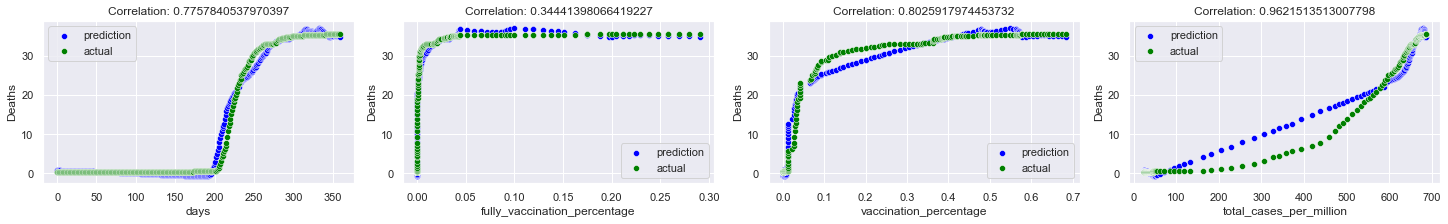

In [156]:
cData, cYData, betaS = {}, {}, {}
for x in dataFrame["location"].drop_duplicates():
    cData[x] = pd.DataFrame.reset_index(dataFrame.loc[(dataFrame['location'] == x), :])
    cYData[x] = pd.DataFrame(cData[x]["total_deaths_per_million"])
    cData[x] = pd.DataFrame(cData[x].loc[:,["days", "fully_vaccination_percentage", "vaccination_percentage", "total_cases_per_million"]])
    

for i in cData:
    xAxis = prepare_x(normalize_z(cData[i]))
    yAxis = prepare_y(cYData[i])
    iterations, alpha, beta1 = 10500, 0.05, np.zeros((xAxis.shape[1], 1))
    beta1 = gradient_descent(xAxis, yAxis, beta1, alpha, iterations)
    betaS[i] = beta1
    fig1, axs1 = plt.subplots(1, 4, figsize=(20, 3), constrained_layout=True)
    prediction1 = pd.DataFrame(predict(normalize_z(cData[i]), beta1))
    val = r2_score(prepare_y(cYData[i]), prediction1).values
    print(i, "- Beta Coefficient: ", [", ".join(x) for x in np.round(beta1, 2).astype(str)])
    print("r^2 Value:", np.round(val, 2), ", Adjusted r^2 Value:", np.round(1-((1-val)*(cData[i].shape[0]-1)/(cData[i].shape[0]-1-cData[i].shape[1])), 2))
    for index1, x in enumerate(cData[i].columns):
        sns.set()
        corr = correlation(cData[i][x], cYData[i]["total_deaths_per_million"])
        scat0 = sns.scatterplot(x=cData[i][x], y=prediction1[0], ax=axs1[index1], color="blue", label="prediction")
        scat1 = sns.scatterplot(x=cData[i][x], y=cYData[i]["total_deaths_per_million"], ax=axs1[index1], color="green", label="actual")
        scat0.set_title("Correlation: " + str(corr**2))
        scat0.set_ylabel("Deaths")
        scat0.set_xlabel(x)
        scat0.legend()
    plt.show()

Prediction for specific countries:

In [161]:
#'Singapore', 'United States', 'United Kingdom', 'Japan', 'Hong Kong', 'New Zealand', 'Australia', 'India', 'South Africa', 'Mexico', 'Russia', 'Brazil', 'South Korea', 'Germany', 'Thailand', 'France', 'Canada', 'Italy', 'Malaysia', 'Taiwan'
# Inpuit country index from the above list and the days away from 1 November 2020
countryIndex, deathInDays = 1, 700

In [162]:
countries = list(cData.keys())
val = cData[countries[countryIndex]].iloc[-1:].copy()
val["days"] = deathInDays
deaths = predict(normalize_predict(cData[countries[countryIndex]], val), betaS[countries[countryIndex]])
print(f'Predicting for {countries[countryIndex]} assuming vaccinated and fully vaccinated did not change')
print("Predicted deaths:", deaths[0][0], ", Last deaths recorded: ", cYData[countries[countryIndex]].values[-1][0])


Predicting for United States assuming vaccinated and fully vaccinated did not change
Predicted deaths: 2224.3947634223155 , Last deaths recorded:  2219.416
